In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

In [2]:
adata = ad.read_h5ad(f'resources/grn_benchmark/evaluation_data/replogle_sc.h5ad', backed='r')

In [3]:
adata

AnnData object with n_obs × n_vars = 1032360 × 8248 backed at 'resources/grn_benchmark/evaluation_data/replogle_sc.h5ad'
    obs: 'perturbation', 'perturbation_type', 'is_tf', 'is_control', 'n_genes'
    var: 'n_cells'
    uns: 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_summary', 'normalization_id'
    layers: 'lognorm'

In [3]:
adata.obs['perturbation'].value_counts()

perturbation
ZNF718    795
ZNF580    736
ZNF574    642
ZNF232    611
NKX2-8    564
         ... 
EN1        17
ZNF260     13
ZNF497     12
HOXC6      11
ZBED2      10
Name: count, Length: 879, dtype: int64

In [10]:
single_cell_counts = adata.obs.groupby('perturbation').size().sort_values(ascending=False)
passed_perturbations = single_cell_counts[single_cell_counts >= 10].index.tolist()
adata[adata.obs['perturbation'].isin(passed_perturbations), :]

/vol/tmp/users/jnourisa/ipykernel_1064109/1203401320.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  single_cell_counts = adata.obs.groupby('perturbation').size().sort_values(ascending=False)


View of AnnData object with n_obs × n_vars = 172694 × 8248 backed at 'resources/grn_benchmark/inference_data/replogle_rna.h5ad'
    obs: 'perturbation', 'perturbation_type', 'is_tf', 'is_control'
    uns: 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_summary', 'normalization_id'
    layers: 'lognorm'

In [39]:
print('Running in test mode...')
filter = adata.obs['gene'][adata.obs['gene'].isin(tf_all)].unique()[0:100]
adata = adata[adata.obs['gene'].isin(filter)].to_memory()  

Running in test mode...


In [ ]:
train_perturbs = adata.obs['perturbation'].unique()

In [ ]:
shortlisted_perts = train_perturbs[:10]

In [17]:
# perturbations = adata[~adata.obs['is_control']].obs['perturbation'].unique()
# tfs = np.intersect1d(tf_all, adata.var_names)


In [ ]:
adata[adata.obs['perturbation'].isin(shortlisted_perts) | adata.obs['is_control'], :]

In [22]:
adata.write(f'resources/grn_benchmark/inference_data/{dataset}_rna.h5ad', compression='gzip')

In [15]:
# - inference_data rna is now subset sc train 
# - extended_data should contain the full sc train
# - move the full sc data to processed folder


View of AnnData object with n_obs × n_vars = 155970 × 8248 backed at 'resources/extended_data/replogle_train_sc.h5ad'
    obs: 'perturbation', 'perturbation_type', 'is_tf', 'is_control', 'sum_by'
    uns: 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_summary', 'normalization_id'
    layers: 'lognorm'

# Overlap of genes in inference and evaluation datasets

In [6]:
for dataset in ['op', 'nakatake', 'norman', 'adamson', 'xaira_HCT116', 'xaira_HEK293T']:
    adata_inference = ad.read_h5ad(f'resources/grn_benchmark/inference_data/{dataset}_rna.h5ad', backed='r')
    adata_evaluation = ad.read_h5ad(f'resources/grn_benchmark/evaluation_data/{dataset}_bulk.h5ad', backed='r')

    inference_genes = adata_inference.var_names
    evaluation_genes = adata_evaluation.var_names

    common_genes = set(adata_inference.var_names).intersection(set(adata_evaluation.var_names))
    union_genes = set(adata_inference.var_names).union(set(adata_evaluation.var_names))
    only_evaluation = set(adata_evaluation.var_names) - set(adata_inference.var_names)

    print(f'{dataset}:', 
            f'Inference genes: {len(inference_genes)}',
            f'Evaluation genes: {len(evaluation_genes)}',
          f'Common genes: {len(common_genes)}',
          f'Union genes: {len(union_genes)}',
          f'Only evaluation genes: {len(only_evaluation)}')

op: Inference genes: 13595 Evaluation genes: 13595 Common genes: 13595 Union genes: 13595 Only evaluation genes: 0
nakatake: Inference genes: 25090 Evaluation genes: 25090 Common genes: 25090 Union genes: 25090 Only evaluation genes: 0
norman: Inference genes: 3459 Evaluation genes: 3511 Common genes: 3372 Union genes: 3598 Only evaluation genes: 139
adamson: Inference genes: 4786 Evaluation genes: 4932 Common genes: 4785 Union genes: 4933 Only evaluation genes: 147


# UMAP of perturbations

In [8]:
!ls resources/extended_data/

adamson_bulk.h5ad  nakatake_bulk.h5ad  replogle_train_sc.h5ad
HCT116_bulk.h5ad   norman_bulk.h5ad    xaira_HCT116_bulk.h5ad
HCT116_sc.h5ad	   op_bulk.h5ad        xaira_HCT116_sc.h5ad
HEK293T_bulk.h5ad  replogle_bulk.h5ad  xaira_HEK293T_bulk.h5ad
HEK293T_sc.h5ad    replogle_sc.h5ad    xaira_HEK293T_sc.h5ad


Processing dataset: xaira_HCT116


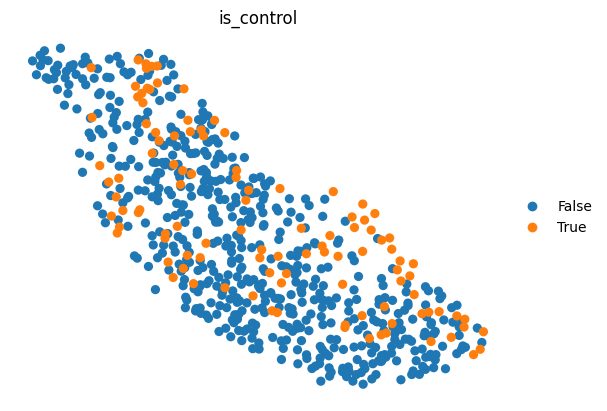

Processing dataset: xaira_HEK293T


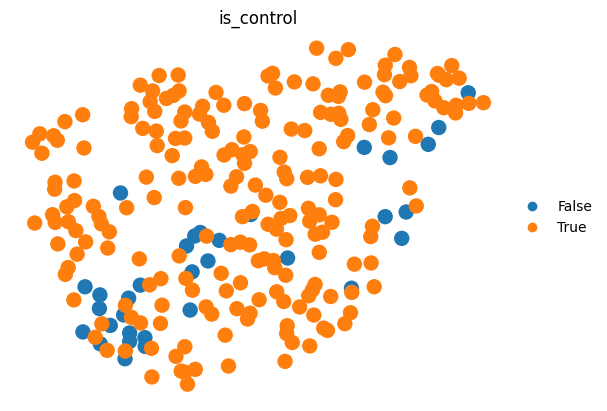

Processing dataset: replogle


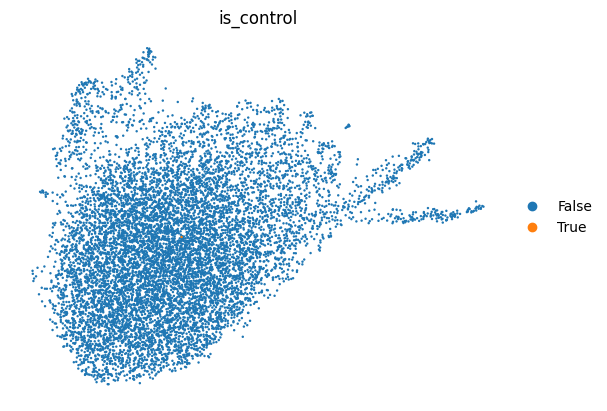

In [11]:
for dataset in ['xaira_HCT116', 'xaira_HEK293T', 'replogle']:
    print(f'Processing dataset: {dataset}')
    adata = ad.read_h5ad(f'resources/extended_data/{dataset}_bulk.h5ad')

    adata.X = adata.layers['lognorm']
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(adata,
        color=['is_control'],
        frameon=False,
        wspace=0.5)

# Assemble the results from differnet runs

In [49]:
!rm -r resources/results/all_main/

In [50]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso

# Rename grnboost2 to grnboost

In [51]:
import os

target_dir = 'resources/results/all_main'

for root, _, files in os.walk(target_dir):
    for fname in files:
        fpath = os.path.join(root, fname)

        # Skip binary files (optional safety)
        try:
            with open(fpath, 'r', encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            continue  # likely a binary file, skip it

        if 'grnboost2' in content:
            content = content.replace('grnboost2', 'grnboost')
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Updated: {fpath}")

Updated: resources/results/all_main/trace.txt
Updated: resources/results/all_main/method_configs.yaml
Updated: resources/results/all_main/score_uns.yaml


## Create Nakatake test

In [8]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/nakatake_rna.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/inference_data/nakatake_rna.h5ad')

In [16]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')